# FINAL PROJECT - SEARCH ENGINE

In [3]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import Counter
from config import *
import math

## 1. LOAD DATA

In [4]:
%%time

with open("data/tweets.json", "rb") as f:
    data = f.readlines()
    data = [json.loads(str_) for str_ in data]

KeyboardInterrupt: 

In [5]:
%%time
df_tweets = pd.DataFrame.from_records(data)

KeyboardInterrupt: 

In [4]:
print(df_tweets.shape)

(500526, 37)


Remove tweets that are not original, i.e. retweets.

In [5]:
tweets = df_tweets[df_tweets['retweeted_status'].isnull()].reset_index()
tweets.shape

(174423, 38)

Remove duplicates

In [6]:
tweets.drop_duplicates(subset = "id", keep = False, inplace = True) 
tweets.shape

(174325, 38)

For all the tweets that were retweets get the underlying original tweet

In [7]:
retweets = df_tweets[~df_tweets['retweeted_status'].isnull()]
retweets.shape

(326103, 37)

In [8]:
original = pd.DataFrame(list(retweets['retweeted_status'].values))
original.shape

(326103, 36)

In [9]:
tweets = pd.concat([tweets, original])

In [10]:
tweets = tweets.reset_index()
tweets.drop(columns = 'index', inplace = True)

In [11]:
tweets.drop_duplicates(subset = "id", keep = False, inplace = True) 
tweets.shape

(189909, 39)

In [12]:
tweets = tweets.reset_index()
tweets.drop(columns = ['index', 'level_0'], inplace = True)

Number of tweets per user in the dataset


In [13]:
users = tweets['user'].apply(lambda x: x['id'])
users.value_counts()

1118075750438064128    295
1269773684518146052    257
1191745846615957506    114
1330563341207678977    109
306127388              102
                      ... 
172832752                1
234484463                1
235211504                1
757121384120213504       1
1330974570514362369      1
Name: user, Length: 143752, dtype: int64

## 2. PREPROCESS TEXT

In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\99per\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict
import re
from array import array
from numpy import linalg as la

The preprocessing steps consists in:

- Remove emojis
- Remove "RT "
- Remove URLs and WebPages
- Remove punctuation
- Convert to lower case
- Remove stopwords
- Perform stemming

In [16]:
def getTerms(text):
    """
    Preprocess the tweet text removing stop words, stemming, transforming to lowercase and return the tokens of the text.
    
    Argument:
    text -- string (tweet) to be preprocessed
    
    Returns:
    text - a list of tokens (words) corresponding to the input tweet after the preprocessing
    """
    
    ## Remove Emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    ## Remove "RT"
    text = text.replace("RT ", "")
     
    ## Remove URLs, webpages
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    
    ## Remove punctuation
    text = re.sub(r'[^\w\s] ', '', text)
    
    ## Transform in lowercase
    text =  text.lower()

    ## Tokenize the text to get a list of terms
    text = text.split() 

    ## Remove stopwords
    stops = set(stopwords.words("english"))    
    text = [word for word in text if not word in stops] 
    
    ## Perform stemming
    stemming = PorterStemmer()
    text = [stemming.stem(word) for word in text] 
    
    return text

## 3. RANKING SCORE TF-IDF

Search engine based on the tweet text data.

In [17]:
def create_index_tfidf(ids, tweets, numDocuments):
    """
    Implement the inverted index for the tweet text and compute the tf, df and idf scores
    
    Argument:
    ids -- tweet ids of the corresponding tweets
    tweets -- collection of tweets
    numDocuments -- total number of tweets
    
    Returns:
    index - the inverted index (implemented through a python dictionary) containing terms as keys and the corresponding 
    list of document these keys appears in (and the positions) as values.
    
    tf - normalized term frequency for each term in each document
    
    df - number of documents each term appear in
    
    idf - inverse document frequency of each term
    """
        
    index = defaultdict(list)
    tf = defaultdict(list)        #term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)         #document frequencies of terms in the corpus
    idf = defaultdict(float)
    
    for i in range(0, len(tweets)): 
        if i % 1000 == 0:
            print(i)
            
        ## ===============================================================        
        ## create the index for the current doc and store it in termdictPage
        ## termdictPage ==> { ‘term1’: [currentdoc, [list of positions]], ..., ‘termn’: [currentdoc, [list of positions]]}
        ## ===============================================================
        
        tweet = tweets[i]
        page_id = ids[i]
        
        termdictPage = {}
        
        terms = getTerms(tweet)
        
        ## Iterate over all terms in the tweet
        for position, term in enumerate(terms): 
            try:
                # if the term is already in the index for the current page (termdictPage)
                # append the position to the corresponding list
                termdictPage[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term] = [page_id, array('I', [position])]
            
        ## Merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage[0])
        
        # normalize term frequencies
        # Compute the denominator to normalize term frequencies
        # norm is the same for all terms of a document.
        norm = 0
        
        for term, posting in termdictPage.items(): 
            # posting is a list containing doc_id and the list of positions for current term in current document: 
            # posting ==> [currentdoc, [list of positions]] 
            norm += len(posting[1])**2
            
        norm = math.sqrt(norm)

        # calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictPage.items():     
            
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1])/norm, 4))  
            
            # increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1  # increment df for current term
            
    # Compute idf 
    for term in df:
        idf[term] = np.round(np.log(float(numDocuments/df[term])), 4)
            
    return index, tf, df, idf

In [18]:
%%time
numDocuments = len(tweets)
index, tf, df, idf = create_index_tfidf(tweets['id'], tweets['text'], numDocuments)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [19]:
def rankDocuments(terms, docs, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    
    Returns:
    Print the list of ranked documents
    """
        
    # I'm interested only on the element of the docVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    docVectors = defaultdict(lambda: [0]*len(terms)) # I call docVectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    queryVector = [0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = Counter(terms) # get the frequency of each term in the query. 
    
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with documents)
        queryVector[termIndex] = query_terms_count[term]/query_norm * idf[term]

        # Generate docVectors for matching docs
        for docIndex, doc in enumerate(index[term]):    
            if doc in docs:
                docVectors[doc][termIndex] = tf[term][docIndex] * idf[term]

    # calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    docScores = [[np.dot(curDocVec, queryVector), doc] for doc, curDocVec in docVectors.items()]
    docScores.sort(reverse = True)
    resultDocs = [x[1] for x in docScores]
    
    #print document titles instead of document id's
    #resultDocs = [ titleIndex[x] for x in resultDocs ]
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)    
    
    return resultDocs

In [20]:
def search_tf_idf(query, index):
    '''
    Outputs the list of documents that contain all of the query terms. 
    
    Argument:
    query -- list of query terms
    index -- inverted index data structure
    
    Returns:
    Return the list of top 10 documents
    
    '''
    query = getTerms(query)
    docs = set()
    
    # Return docs that contain all query terms
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs = [posting for posting in index[term]]

            # No documents had been stored yet
            if len(docs) == 0:
                docs = docs.union(termDocs)
            
            # Store only documents that are in both sets, meaning that they contained previous terms and current term
            else:
                docs = docs.intersection(termDocs)

        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs = rankDocuments(query, docs, index, idf, tf)   
    return ranked_docs

Display relevant tweet information in a dataframe format.

**Tweet	| Username | Date | Hashtags | Likes | Retweets | Url**

The URL field has been not included since the JSON object does not contain the url of the tweet in question, but only the URLs that appear in the tweet. 

In [1]:
def print_tweet_info(tweets, docs):
    
    i = 1
    for doc_id in docs:
        tweet = tweets[tweets['id'] == doc_id]
        user = tweet['user'].item()
        entities = tweet['entities'].item()
        hashtags = [hashtag['text'] for hashtag in entities['hashtags']]
        
        print(str(i) + '. \tTweet: ' + tweet['text'].item() + '\t User: ' + user['screen_name'] + '\t Date: ' + 
              tweet['created_at'].item() + '\t Hashtags: ' + str(hashtags) + '\t Likes: ' + 
              str(tweet['favorite_count'].item()) + '\t Retweets: ' + str(tweet['retweet_count'].item()))
        i = i + 1

Query results for TF-IDF

In [2]:
print("Insert your query:\n")
query = input()
ranked_docs = search_tf_idf(query, index)    
top = 20

print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
print_tweet_info(tweets, ranked_docs[:top])

Insert your query:

hi


NameError: name 'search_tf_idf' is not defined

## 4. RANKING - OUR SCORE

The score we have defined establishes that the higher the number of interactions with the tweet, the more relevant it will be.

Interaction Score = Retweets + Likes + Quotes + Replies

In [23]:
def create_index_score(ids, tweets, retweets, likes, quotes, replies, numDocuments):
    """
    Implement the inverted index for the tweet text and compute the interaction score
    
    Argument:
    ids -- collection of ids of the corresponding tweets
    tweets -- collection of tweets
    numDocuments -- total number of tweets
    
    Returns:
    index - the inverted index containing terms as keys and the corresponding list of document these keys appears in.
    score - number of interactions with a tweet
    """
    
    index = defaultdict(list)
    score = defaultdict(int)         #document frequencies of terms in the corpus
    
    for i in range(0, len(tweets)): 
        if i % 1000 == 0:
            print(i)
            
        ## ===============================================================        
        ## create the index for the current doc and store it in termdictPage
        ## termdictPage ==> { ‘term1’: [currentdoc, ...], ..., ‘termn’: [currentdoc, ...]}
        ## ===============================================================
        
        tweet = tweets[i]
        page_id = ids[i]
        
        termdictPage = {}
        
        terms = getTerms(tweet)
        
        ## Iterate over all terms in the tweet
        for position, term in enumerate(terms): 
            try:
                # if the term is already in the index for the current page (termdictPage)
                # append the position to the corresponding list
                termdictPage[term][1].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictPage[term] = [page_id, array('I', [position])]
        
        ## Merge the current page index with the main index
        for termpage, postingpage in termdictPage.items():
            index[termpage].append(postingpage[0])
        
        # Compute the score for each page
        score[page_id] = retweets[i] + likes[i] + quotes[i] + replies[i]
            
    return index, score

In [24]:
%%time
numDocuments = len(tweets)
index, score = create_index_score(tweets['id'], tweets['text'], tweets['retweet_count'], 
                                  tweets['favorite_count'], tweets['quote_count'], tweets['reply_count'], numDocuments)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [25]:
def rankDocuments_score(terms, docs, index, score):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    score -- number of tweet interactions
    
    Returns:
    Print the list of ranked documents
    """
        
    docScores = [[score[doc], doc] for doc in docs]
    docScores.sort(reverse = True)
    resultDocs = [x[1] for x in docScores]
    
    if len(resultDocs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)    
    
    return resultDocs

In [26]:
def search_score(query, index):
    '''
    Outputs the list of documents that contain all of the query terms. 
    
    Argument:
    query -- list of query terms
    index -- inverted index data structure
    
    Returns:
    Return the list of top 10 documents
    
    '''
    query = getTerms(query)
    docs = set()
    
    # Return docs that contain all query terms
    for term in query:
        try:
            # store in termDocs the ids of the docs that contain "term"                        
            termDocs = [posting for posting in index[term]]

            # No documents had been stored yet
            if len(docs) == 0:
                docs = docs.union(termDocs)

            # Store only documents that are in both sets, meaning that they contained previous terms and current term
            else:
                docs = docs.intersection(termDocs)

        except:
            #term is not in index
            pass
    docs = list(docs)
    
    ranked_docs = rankDocuments_score(query, docs, index, score)   
    return ranked_docs

Display relevant tweet information in a dataframe format.

**Tweet	| Username | Date | Hashtags | Likes | Retweets | Quotes | Replies**

The URL field has been not included since the JSON object does not contain the url of the tweet in question, but only the URLs that appear in the tweet. 

In [27]:
def print_tweet_info(tweets, docs):
    
    i = 1
    for doc_id in docs:
        tweet = tweets[tweets['id'] == doc_id]
        user = tweet['user'].item()
        entities = tweet['entities'].item()
        hashtags = [hashtag['text'] for hashtag in entities['hashtags']]
        
        print(str(i) + '. \tTweet: ' + tweet['text'].item() + '\t User: ' + user['screen_name'] + '\t Date: ' + 
              tweet['created_at'].item() + '\t Hashtags: ' + str(hashtags) + '\t Likes: ' + 
              str(tweet['favorite_count'].item()) + '\t Retweets: ' + str(tweet['retweet_count'].item()) + '\t Quotes: ' 
              + str(tweet['quote_count'].item()) + '\t Replies: ' + str(tweet['reply_count'].item()))
        i = i + 1

In [28]:
print("Insert your query:\n")
query = input()
ranked_docs = search_score(query, index)    
top = 20

print("\n======================\nTop {} results out of {} for the seached query:\n".format(top, len(ranked_docs)))
print(print_tweet_info(tweets, ranked_docs[:top]))

Insert your query:

virus

Top 20 results out of 8591 for the seached query:

1. 	Tweet: stardew valley comes with this crazy virus that forces google chrome to open 53 tabs of stardewvalleywiki, 7 of the… https://t.co/pFoRRKkA5p	 User: _itsjackielee	 Date: Wed Jan 22 05:51:09 +0000 2020	 Hashtags: []	 Likes: 52555	 Retweets: 14150	 Quotes: 531	 Replies: 270
2. 	Tweet: The scariest thing about this Corona Virus is that you being careful is not enough, because your survival also depe… https://t.co/dgDStjp4Vp	 User: Deshysmalls	 Date: Sun Mar 22 17:35:16 +0000 2020	 Hashtags: []	 Likes: 32421	 Retweets: 18205	 Quotes: 548	 Replies: 251
3. 	Tweet: Nancy Pelosi is an 80-year-old virus without a cure.	 User: MrMichaelBurkes	 Date: Wed Nov 18 18:01:53 +0000 2020	 Hashtags: []	 Likes: 37033	 Retweets: 5553	 Quotes: 665	 Replies: 1130
4. 	Tweet: PPL RLY THINK THE VIRUS WILL MAGICALLY VANISH ON JANUARY 1ST, 2021 😩😩😩	 User: quackity4k	 Date: Sun Oct 11 19:25:32 +0000 2020	 Hashtags: []	 Likes: 3

## 5. WORDCLOUD

In [29]:
from wordcloud import WordCloud, ImageColorGenerator

In [30]:
def preprocess(text):
    ## Remove Emojis
    text = text.encode('ascii', 'ignore').decode('ascii')

    ## Remove "RT"
    text = text.replace("RT ", "")
     
    ## Remove URLs, webpages
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', text)
    
    ## Remove punctuation
    text = re.sub(r'[^\w\s] ', '', text)
    
    ## Transform in lowercase
    text =  text.lower()

    ## Tokenize the text to get a list of terms
    lst_text = text.split() 

    ## Remove stopwords
    lst_text = [word for word in lst_text if not word in stops] 
    return lst_text

In [31]:
stops = set(stopwords.words("english")) 
bag_of_words = {}

for text in tweets["text"]:
     
    lst_text = preprocess(text)
    
    # create bag-of-words - for each word the frequency of the word in the corpus
    for word in lst_text:
        if word not in bag_of_words:
            bag_of_words[word] = 0
        bag_of_words[word] += 1

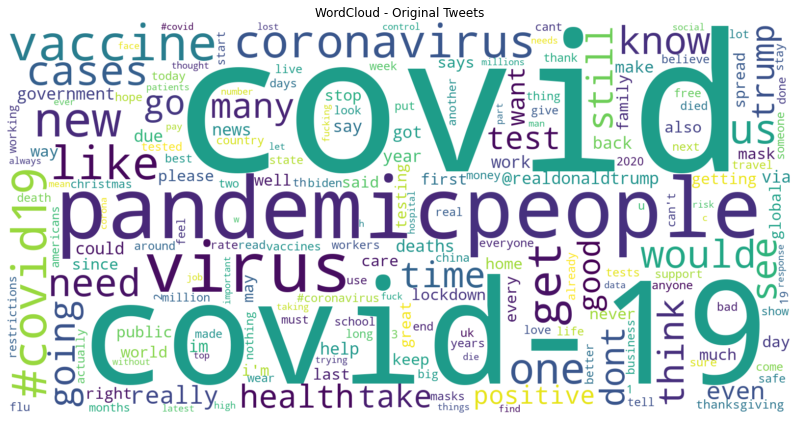

In [32]:
def plot_wordcloud(title, dic_):
    
    fig, ax = plt.subplots(1, 1, figsize = (18,7))
    wordcloud = WordCloud(background_color = "white", width = 1600, height = 800)
    wordcloud = wordcloud.generate_from_frequencies(dic_)
    ax.axis("off")     
    ax.imshow(wordcloud, interpolation = 'bilinear')

    ax.set_title(title)
    plt.tight_layout()
    fig.subplots_adjust(top = 0.8)
    plt.show()

plot_wordcloud("WordCloud - Original Tweets", bag_of_words)

## 6. BAR PLOT OF 10 MOST FREQUENT WORDS

In [46]:
sorted_dict = {}
sorted_keys = sorted(bag_of_words, key = bag_of_words.get, reverse = True)

for w in sorted_keys:
    sorted_dict[w] = bag_of_words[w]

In [49]:
most_freq = 10 
top = dict(list(sorted_dict.items())[:most_freq])

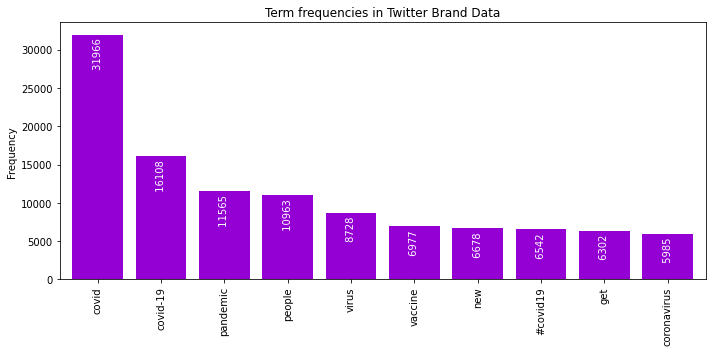

In [57]:
y = [count for tag, count in top.items()]
x = [tag for tag, count in top.items()]

plt.figure(figsize = (10, 5))
plt.bar(x, y, color = "darkviolet")
plt.title("Term frequencies in Twitter Data")
plt.ylabel("Frequency")
plt.xticks(rotation = 90)
for i, tag in enumerate(top):
    plt.text(i, y[i], f" {y[i]} ", rotation = 90, ha = "center", va = "top" if i < 10 else "bottom", 
             color = "white" if i < 10 else "black")
plt.xlim(-0.6, len(x)-0.4) 
plt.tight_layout()
plt.show()